### Creating Simple Strategies

`TODO: Write some introductions for the following topics. Need to decide what the target audience for this notebook is so I can get full marks from English prof jk.`

#### Backtesting Philosophy

#### Beware: Overfitting

#### Training, Testing, and Validation Sets

#### TST: Market-Neutral, Medium Holding Strategies

Explain the trading strategies of TST.

#### Sample Strategy: 1d_fwd_return

We can get access to historical prices through links such as [this one](https://coinmarketcap.com/currencies/ripple/historical-data/?start=20171104&end=20180204).

The format of this data is quite easy to copy-and-paste, so it is unneccessary to write a web scraper at the moment. Data can be saved into the following format.

In [1]:
%%bash

head xrp_daily.raw


Date	Open	High	Low	Close	Volume	Market Cap
Feb 20, 2018	1.14	1.17	1.08	1.09	806,673,000	44,648,100,000
Feb 19, 2018	1.12	1.17	1.12	1.14	556,304,000	43,813,300,000
Feb 18, 2018	1.20	1.21	1.09	1.12	1,113,650,000	46,997,500,000
Feb 17, 2018	1.14	1.22	1.13	1.20	1,186,730,000	44,370,200,000
Feb 16, 2018	1.14	1.15	1.11	1.14	568,339,000	44,663,300,000
Feb 15, 2018	1.14	1.16	1.11	1.15	1,188,530,000	44,433,600,000
Feb 14, 2018	1.03	1.17	1.02	1.14	1,457,600,000	40,026,500,000
Feb 13, 2018	1.08	1.08	1.01	1.03	921,100,000	42,119,800,000
Feb 12, 2018	1.01	1.11	1.01	1.08	1,756,290,000	39,262,700,000


We want to move this data into a more analytics-friendly format by moving in into standard CSV formatting.

In [2]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.decomposition import PCA
import math
import numpy as np

df = pd.read_csv('xrp_daily.raw', sep='\t').infer_objects()
df = df.rename(index=str, columns={"Date": "date", "Open": "open", "High": "high", "Low": "low", 
                              "Close": "close", "Volume": "volume", "Market Cap": "mktcap"})

df.volume = df.volume.apply(lambda v: int(v.replace(',', '')))
df.mktcap = df.mktcap.apply(lambda m: int(m.replace(',', '')))
df.date = df.date.apply(lambda d: datetime.strptime(d, "%b %d, %Y").strftime("%Y-%m-%d"))
df = df.iloc[::-1].reset_index(drop=True)

df.to_csv("/Users/lola/xrp_daily.csv", index=False)
df.tail()

,date,open,high,low,close,volume,mktcap
229,2018-02-16,1.14,1.15,1.11,1.14,568339000,44663300000
230,2018-02-17,1.14,1.22,1.13,1.20,1186730000,44370200000
231,2018-02-18,1.20,1.21,1.09,1.12,1113650000,46997500000
232,2018-02-19,1.12,1.17,1.12,1.14,556304000,43813300000
233,2018-02-20,1.14,1.17,1.08,1.09,806673000,44648100000


_This section is in progress. Please scroll to the next italicized text_

Before we train models on this data, we should first partition our data so we know what we can use as our training data. By examining some XRP data from [this chart](https://coinmarketcap.com/currencies/ripple/), I decided to ignore data before December 15th (during the obscure and bubble eras).

We will look for clusters within our data of pricing and volume to see if any interesting patterns emerge.

First, we'll begin by looking at the `volume` field.

(array([ 25.,  12.,  10.,   8.,   3.,   2.,   2.,   2.,   3.,   1.]),
 array([  5.56304000e+08,   1.41171760e+09,   2.26713120e+09,
          3.12254480e+09,   3.97795840e+09,   4.83337200e+09,
          5.68878560e+09,   6.54419920e+09,   7.39961280e+09,
          8.25502640e+09,   9.11044000e+09]),
 <a list of 10 Patch objects>)

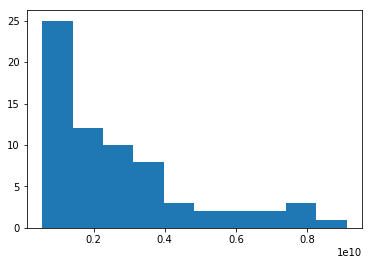

In [3]:
%matplotlib inline

df = df[df.date >= '2017-12-15']
plt.hist(df.volume)


As we expect, this distribution is skewed right, meaning that trading volume is usually quite stable but there are certain days where it spikes. Thus, we will first normalize our data by applying a log transformation. We can see that pricing is more evenly distributed.

(array([  4.,   6.,  11.,   8.,   8.,  10.,   8.,   4.,   4.,   5.]),
 array([-1.84377933, -1.45502856, -1.0662778 , -0.67752703, -0.28877626,
         0.09997451,  0.48872528,  0.87747605,  1.26622682,  1.65497759,
         2.04372836]),
 <a list of 10 Patch objects>)

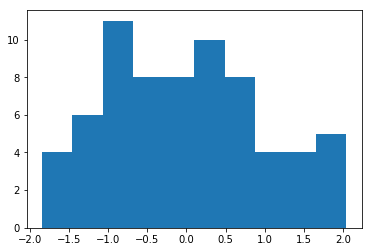

In [4]:
df.volume = df.volume.apply(math.log)
plt.hist(preprocessing.scale(df.volume))

Before we move on, we will look for correlations between our fields show evidence that dimensionality reduction is plausible. 


Slope: 0.9438466494369677, Intercept0.08489942028862285, r_value: 0.9477295397151337


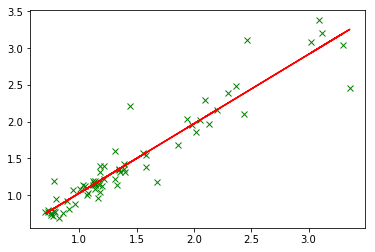

Slope: 0.8712721698223572, Intercept0.0422810382293195, r_value: 0.9551733201575323


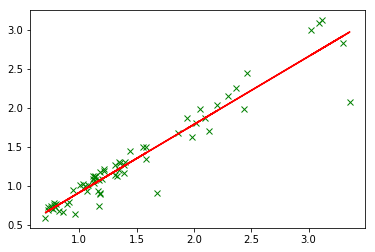

Slope: 1.1078690498991295, Intercept-0.020377353236839646, r_value: 0.972934174645117


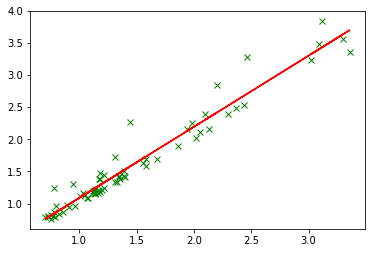

Slope: 0.5458414055397902, Intercept20.671289948149788, r_value: 0.5070235067447765


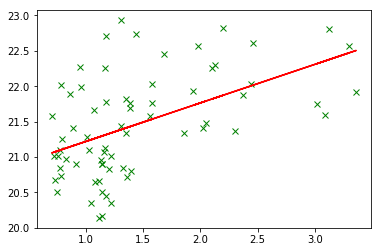

Slope: 38678187075.95013, Intercept165173236.6541214, r_value: 0.9999817896347468


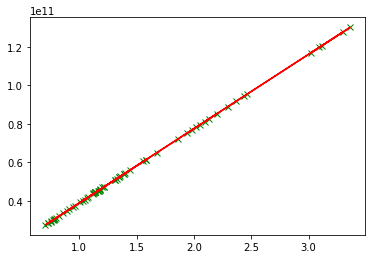

In [5]:
def plot_corr(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'Slope: {slope}, Intercept{intercept}, r_value: {r_value}')
    plt.plot(x, y, "gx")
    plt.plot(x, intercept + slope*x, 'r')
    plt.show()
    
plot_corr(df.open, df.close)
plot_corr(df.open, df.low)
plot_corr(df.open, df.high)
plot_corr(df.open, df.volume)
plot_corr(df.open, df.mktcap)

As we expect, opening prices have a strong correlation with closing prices, lows, and highs - this suggests that dimensionality reduction would be a good approach. 

We also see that `open` has a perfect correlation with `mktcap`, which isn't suprising since XRP is pre-mined, so the number of units available is always constant. It may be worthwhile to note that CoinMarketCap uses opening prices when calculating their marketcaps. From an analytic perspective, this means that we have a linearly-dependent field that we can essentially exclude from our further calculations.

TODO: Apply dimensionalty reduction

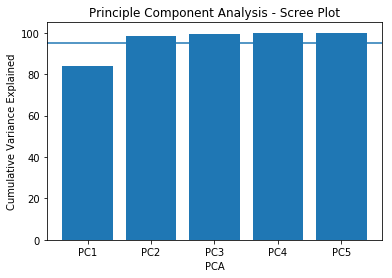

The first two PCA explain 98.41% of our variance.


In [6]:
df2 = df[['open', 'close', 'low', 'high', 'volume']]
pca = PCA()
pca.fit(df2)
pca_data = pca.transform(df2)

perc_var = np.cumsum(np.round(pca.explained_variance_ratio_*100, decimals=2))
labels = ['PC' + str(i) for i in range(1, 6)]

plt.bar(labels, perc_var)
plt.axhline(y=95)

plt.title('Principle Component Analysis - Scree Plot')
plt.xlabel('PCA')
plt.ylabel('Cumulative Variance Explained')
plt.show()

print(f"The first two PCA explain {perc_var[1]}% of our variance.")

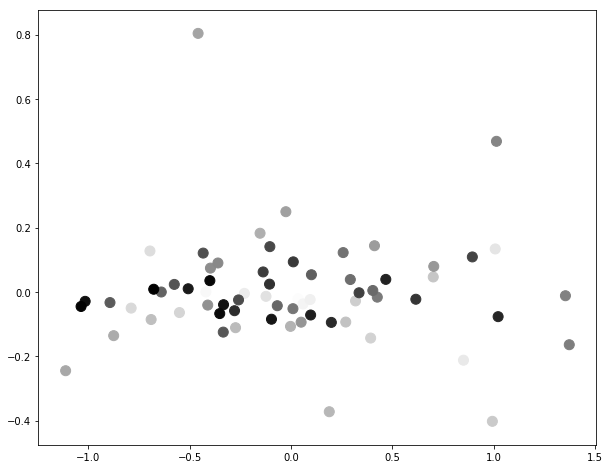

In [7]:
from datetime import datetime
pca_df = pd.DataFrame({'date': df.date, 'pc1': pca_data[:,1], 'pc2':pca_data[:,2]})

dt_colors = df.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

plt.figure(figsize=(10, 8))
plt.scatter(pca_df.pc1, pca_df.pc2, s=100, c=dt_colors, cmap='binary')
#for sample in pca_df.date.index:
 #   plt.annotate(datetime.strptime(pca_df.date[sample], '%Y-%m-%d').strftime('%-m-%-d'),
  #              (pca_df.pc1.loc[sample], pca_df.pc2.loc[sample]))
plt.show()

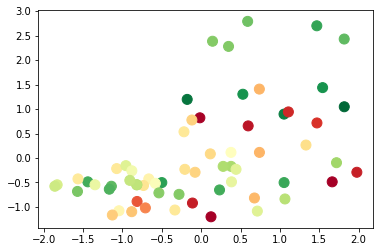

In [8]:
n = 5
delta_nd = df.open.diff(n) / df.open
plt.scatter(preprocessing.scale(df.volume[n:]),
            preprocessing.scale(df.open[n:]), 
            s=100, 
            c=preprocessing.minmax_scale(delta_nd[n:]),
            cmap='RdYlGn'
           )

_Continue Reading_

For each coin, we will subset its pricing history for relevant training data. We will partition a small amount into the test set, and run validation testing with mock trails on live data. Performance on live data will indicate whether or not strategies should be implemented in production. 

In [9]:
# close_1d.close.sub(df.close.iloc[1:])

print(df.iloc[-5:], '\n\n', (df.close.diff() / df.close)[-10:])
perc_change_1d = (df.close.diff() / df.close)

print(perc_change_1d.head())
print(perc_change_1d.tail())
# TODO: Fix offsets


           date  open  high   low  close     volume       mktcap
229  2018-02-16  1.14  1.15  1.11   1.14  20.158229  44663300000
230  2018-02-17  1.14  1.22  1.13   1.20  20.894467  44370200000
231  2018-02-18  1.20  1.21  1.09   1.12  20.830909  46997500000
232  2018-02-19  1.12  1.17  1.12   1.14  20.136825  43813300000
233  2018-02-20  1.14  1.17  1.08   1.09  20.508429  44648100000 

 224   -0.070000
225    0.074074
226   -0.048544
227    0.096491
228    0.008696
229   -0.008772
230    0.050000
231   -0.071429
232    0.017544
233   -0.045872
Name: close, dtype: float64
166         NaN
167    0.003244
168   -0.041567
169    0.064286
170    0.016240
Name: close, dtype: float64
229   -0.008772
230    0.050000
231   -0.071429
232    0.017544
233   -0.045872
Name: close, dtype: float64


Slope: 0.05850265826365977, Intercept-0.0024690203639627234, r_value: 0.05845031092890196


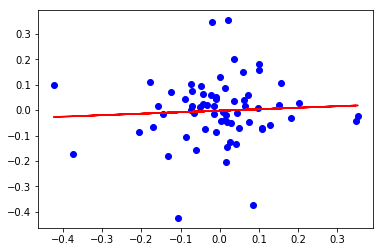

In [10]:
x, y = perc_change_1d[1:-1], perc_change_1d[2:]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f'Slope: {slope}, Intercept{intercept}, r_value: {r_value}')

plt.plot(x, y, "bo")
plt.plot(x, intercept + slope*x, 'r')
plt.show()

Slope: 0.0827320849967005, Intercept-0.0012128050391596674, r_value: 0.08348439810698065


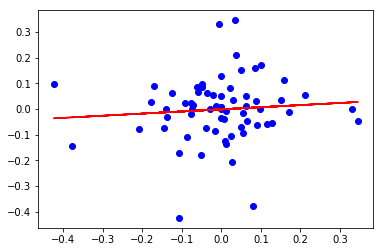

In [11]:
# We try the same methodology with Open prices:

perc_change_1d = (df.open.diff() / df.open)

x, y = perc_change_1d[1:-1], perc_change_1d[2:]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f'Slope: {slope}, Intercept{intercept}, r_value: {r_value}')

plt.plot(x, y, "bo")
plt.plot(x, intercept + slope*x, 'r')
plt.show()

From here, we can see that 1-dforward returns have a slightly negative correlation with future returns. This suggests that reversion-based strategies may be more rewarding on the 1-day time horizion.

We can encapsulate the functionality of the above code as follows:

Slope: 0.24393480609712265, Intercept: -0.03681726387723242, r_value: 0.25356892605489756


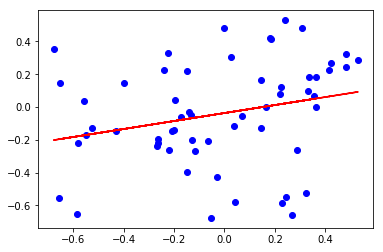

In [12]:
def plot_nday_fwd_returns(data, n):
    delta_nd = data.diff(n) / data
    x, y = delta_nd[n:-n], delta_nd[2*n:]    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'Slope: {slope}, Intercept: {intercept}, r_value: {r_value}')
    plt.plot(x, y, "bo")
    plt.plot(x, intercept + slope*x, 'r')
    plt.show()
    
plot_nday_fwd_returns(df.close, 5)

We see that we get the strongest correlation for forward returns when $n = 5$.